Almost all the error comes from the CNOT gates. Lets investigate whether this varies with beta

## Hardware

In [51]:
run_on_hardware = True

### Set up server

In [52]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.measure_all()
    return qc

### submit to run on ibm hardware

In [53]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 1
shots = 2**15
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}

if run_on_hardware:
    with Batch(backend=backend) as batch:
        for repeats in range(repeat_num):
            error_rates = []
            for gamma_val in gamma_values:
                # noise
                # qc.assign_parameters({gamma: gamma_val})
                qc = make_circuit(gamma=gamma_val)
                isa_qc = pm_noisy.run(qc)
                sampler = Sampler(mode=batch) #Sampler(mode=simulator)
                job = sampler.run([isa_qc], shots=shots)

qiskit_runtime_service.check_pending_jobs:WARNING:2025-04-02 14:12:02,332: The pending jobs limit has been reached. Waiting for job <RuntimeJob('czpkf5mrxz8g008dmf60', 'sampler')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'409 Client Error: Conflict for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"You have reached the limit of 3 pending  jobs. Please wait for a job to complete or cancel one before submitting anything new.","code":3458,"solution":"Wait until some previous jobs were finished. You can cancel pending jobs to run new jobs.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

### Fetch results from ibm server
Easiest to just grab job ids manually - know it will keep on working

In [ ]:
job_ids_1 = ["czkc0h2qw630008tbfjg", "czkc0b1qw630008tbfg0",
"czkc030qw630008tbfd0","czkbzyfp3xeg008h50mg",
"czkbzszp3xeg008h50j0","czkbznepj4bg008yvaqg",
"czkbzddpj4bg008yvahg","czkbz8na980g008hgx80",
"czkbz44qw630008tbewg","czkbyv3qw630008tbes0",
"czkbymj112c0008amy2g","czkbydhpj4bg008yva5g",
"czkby91112c0008amxtg","czkby08qw630008tbeag",
"czkbxt7a980g008hgwng","czkbxnpp3xeg008h4z5g",
"czkbxe5p3xeg008h4z10","czkbx6mtj3e0008jprkg",
"czkbx64tj3e0008jprhg","czkbx5ma980g008hgwbg"]

In [ ]:
job_ids_2 = ["czkc0h2qw630008tbfjg", "czkc0b1qw630008tbfg0",
"czkc030qw630008tbfd0","czkbzyfp3xeg008h50mg",
"czkbzszp3xeg008h50j0","czkbznepj4bg008yvaqg",
"czkbzddpj4bg008yvahg","czkbz8na980g008hgx80",
"czkbz44qw630008tbewg","czkbyv3qw630008tbes0",
"czkbymj112c0008amy2g","czkbydhpj4bg008yva5g",
"czkby91112c0008amxtg","czkby08qw630008tbeag",
"czkbxt7a980g008hgwng","czkbxnpp3xeg008h4z5g",
"czkbxe5p3xeg008h4z10","czkbx6mtj3e0008jprkg",
"czkbx64tj3e0008jprhg","czkbx5ma980g008hgwbg"]

In [45]:
def process_batch_results(ids:list[str]):
    """from list of job id strings get the results from ibm
    server and put them into a dict to be plotted"""
    count = 0
    for repeats in range(repeat_num):
        for gamma_val in gamma_values:      
            # expect them all with equal probability
            # produce error plots for each possibility
            results = service.job(job_id=ids[count]).result()
            count += 1
            for outcome in poss_outcomes:
                outcome_num = results[0].data.meas.get_counts().get(outcome, 0)
                outcome_diff = [abs(outcome_num - shots/4)]
                results_dict[outcome]["gamma"].append(gamma_val)
                results_dict[outcome][f"rep{repeats}"].append(outcome_diff)



In [46]:
results_dict = process_batch_results(job_ids_1)

### plot

In [ ]:
# Plot results
def plot_results(results_plot, fname):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs_flat = axs.flatten()
    clrs = ["b", "r", "g", "m"]
    for i, outcome in enumerate(poss_outcomes):
        axs_flat[i].plot(np.array(results_plot[outcome]["gamma"])/np.pi,
                np.array(results_plot[outcome]["rep0"])/(shots/4),
                marker="o", linestyle="-", color=clrs[i], label=f"ZZ Error: {outcome}")
        # plt.figure(figsize=(8, 5))
        # plt.errorbar(gamma_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
        #              )
        axs_flat[i].set_xlabel(r"γ/pi  (rotation angle)")
        axs_flat[i].set_ylabel("Error rate")
        # axs_flat[i].set_title("Error Rate of ZZ Mixer Gate on IBM Noise Model")
        axs_flat[i].legend()
        axs_flat[i].grid()
    # ax.show()
    plt.savefig(fname, bbox_inches="tight")

TypeError: 'NoneType' object is not subscriptable

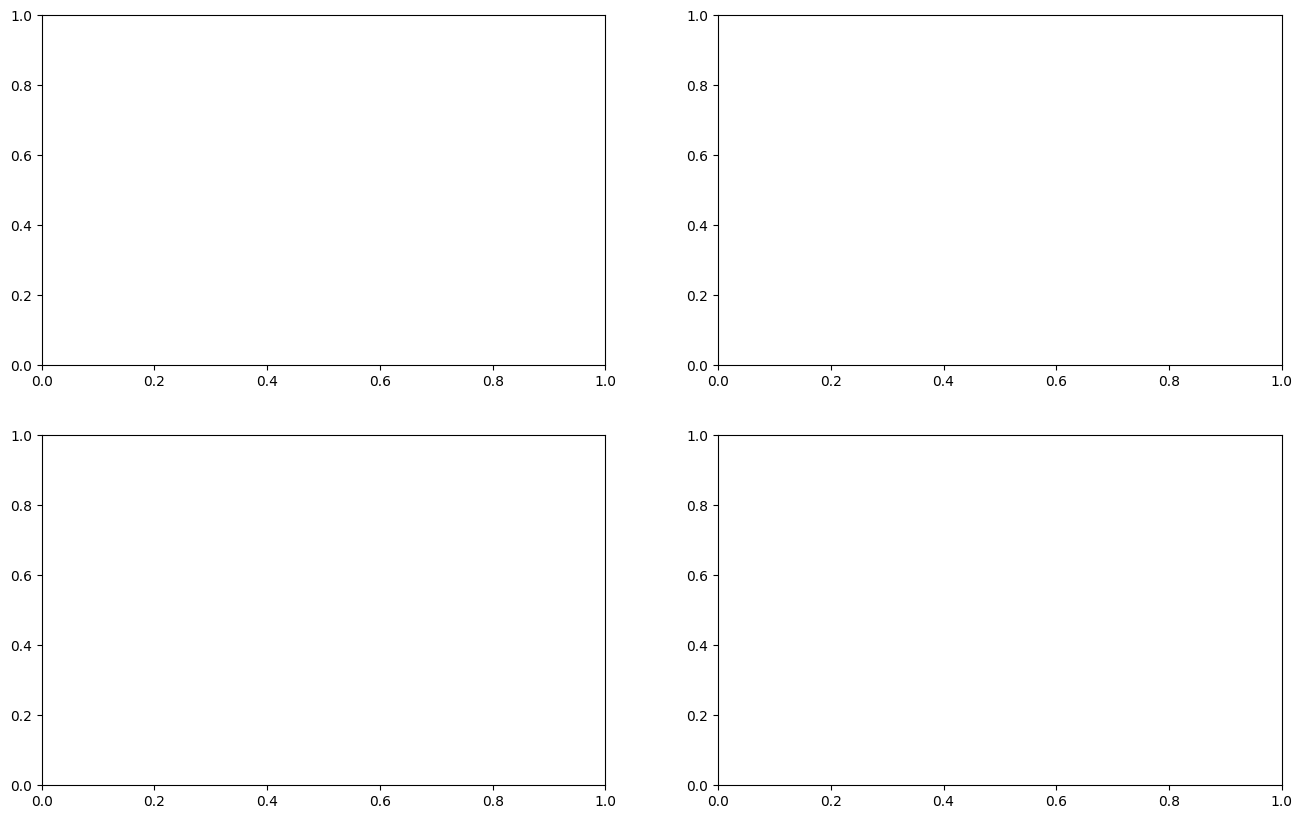

In [48]:
plot_results(results_dict, fname="plots/rzz_err_by_angle_hardware.png")

## Simulator

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.measure_all()
    return qc

DataBin(meas=BitArray(<shape=(), num_shots=65536, num_bits=1>))

In [ ]:
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
# pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
from qiskit_ibm_runtime import Batch
# simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
backend = service.backend("ibm_brisbane")
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define rotation angles to test
gamma_values = np.pi*np.linspace(0, 1, 20)  # Test 50 angles between 0 and π

# some parameters
repeat_num = 1
shots = 2**16
poss_outcomes = ["00", "01", "10", "11"]
name_per_outc = ["gamma"] + [f"rep{rep_num}" for rep_num in range(repeat_num)]
results_dict = {outcome: {name : [] for name in name_per_outc} for outcome in poss_outcomes}
ids = []
count = 3
with Batch(backend=backend) as batch:
    for repeats in range(repeat_num):
        error_rates = []
        for gamma_val in gamma_values:
            # noise
            # qc.assign_parameters({gamma: gamma_val})
            qc = make_circuit(gamma=gamma_val)
            isa_qc = pm_noisy.run(qc)
            sampler = Sampler(mode=batch) #Sampler(mode=simulator)
            job = sampler.run([isa_qc], shots=shots)
            
            # some packing
            result_noise = service.job(job_id=ids[count]).results()
            count += 1
            err_per_outcome = []
            for outcome in poss_outcomes:
                outcome_num = result_noise[0].data.meas.get_counts().get(outcome, 0)
                outcome_diff = [abs(outcome_num - shots/4)]
                results_dict[outcome]["gamma"].append(gamma_val)
                results_dict[outcome][f"rep{repeats}"].append(outcome_diff)





In [ ]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs_flat = axs.flatten()
clrs = ["b", "r", "g", "m"]
for i, outcome in enumerate(poss_outcomes):
    axs_flat[i].plot(np.array(results_dict[outcome]["gamma"])/np.pi,
            np.array(results_dict[outcome]["rep0"])/(shots/4),
            marker="o", linestyle="-", color=clrs[i], label=f"ZZ Error: {outcome}")
    # plt.figure(figsize=(8, 5))
    # plt.errorbar(gamma_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
    #              )
    axs_flat[i].set_xlabel(r"γ/pi  (rotation angle)")
    axs_flat[i].set_ylabel("Error rate")
    # axs_flat[i].set_title("Error Rate of ZZ Mixer Gate on IBM Noise Model")
    axs_flat[i].legend()
    axs_flat[i].grid()
# ax.show()
plt.savefig("rzz_err_by_angle_simulator.png", bbox_inches="tight")